In [1]:
from fastai.vision import *
from pathlib import Path
import pandas as pd
from IPython.display import Image
from cv2 import *
from matplotlib import pyplot as plt

In [2]:
path=Path('../../../../Documents/data')

In [3]:
path.ls()

[PosixPath('../../../../Documents/data/allAnnotations.csv'),
 PosixPath('../../../../Documents/data/models'),
 PosixPath('../../../../Documents/data/images')]

In [4]:
data = pd.read_csv(path/"allAnnotations.csv", delimiter=';')

In [5]:
data.columns

Index(['Filename', 'Annotation tag', 'Upper left corner X',
       'Upper left corner Y', 'Lower right corner X', 'Lower right corner Y',
       'Occluded,On another road', 'Origin file', 'Origin frame number',
       'Origin track', 'Origin track frame number'],
      dtype='object')

In [6]:
data['Filename'][0]

'aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/stop_1330545910.avi_image0.png'

In [7]:
img_filename = data['Filename'][0].split('/')[-1]

In [8]:
path/'images'/img_filename

PosixPath('../../../../Documents/data/images/stop_1330545910.avi_image0.png')

In [9]:
img = cv2.imread(str(path/'images'/img_filename))

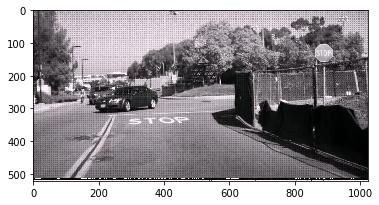

In [10]:
plt.imshow(img)

In [11]:
upLeftX = data['Upper left corner X'][0]
upLeftY = data['Upper left corner Y'][0]
downRightX = data['Lower right corner X'][0]
downRightY = data['Lower right corner Y'][0]

In [12]:
upLeftX, upLeftY

(862, 104)

In [13]:
downRightX, downRightY

(916, 158)

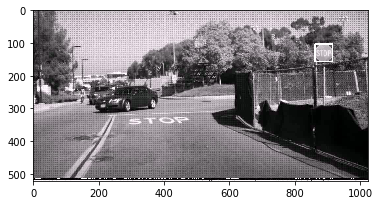

In [14]:
alt_image = img

alt_image[upLeftY:downRightY, upLeftX-2:upLeftX+2] = 255
alt_image[upLeftY:downRightY,downRightX-2:downRightX+2] = 255
alt_image[upLeftY-2:upLeftY+2,upLeftX:downRightX] = 255
alt_image[downRightY-2:downRightY+2,upLeftX:downRightX] = 255

plt.imshow(alt_image)

In [15]:
df = pd.DataFrame(data)

In [16]:
classes = ['keepRight', 'pedestrianCrossing', 'signalAhead', 'speedLimit35', 'stop']
pat = r'([a-zA-Z0-9]*)*'

In [17]:
images = []
lbl_bbox = []
for row in data.iterrows():
    filename_label = re.search(pat,row[1][0].split('/')[-1]).group(0)
    if (filename_label in classes):
        images.append(row[1][0].split('/')[-1])
        lbl_bbox.append([[[
            row[1][3],row[1][2],row[1][5],row[1][4]
            ]], 
            [row[1][1]]])

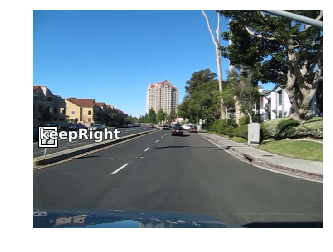

In [18]:
i=-1
img = open_image(path/'images'/images[i])
bbox = ImageBBox.create(*img.size, lbl_bbox[i][0], [0], classes=lbl_bbox[i][1])
img.show(figsize=(6,4), y=bbox)

In [19]:
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [20]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(path/'images')
    src = src.split_by_rand_pct(0.2)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(max_rotate=0), size=size, tfm_y=True)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)

In [21]:
data = get_data(bs=64,size=256)

ImageDataBunch;

Train: LabelList (2759 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: ../../../../Documents/data/images;

Valid: LabelList (689 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: ../../../../Documents/data/images;

Test: None

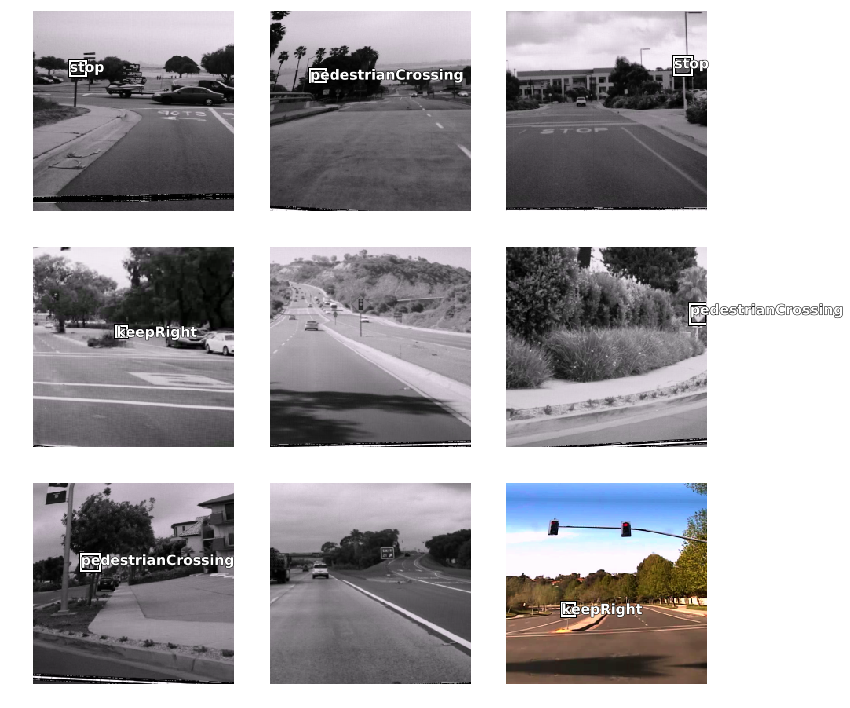

In [22]:
data.show_batch(rows=3, figsize=(10,10))
data

In [24]:
custom_head = nn.Sequential(
    AdaptiveConcatPool2d((4,4)),
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(16384,256), #2*512*4*4
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4))

In [25]:
class MyLoss(nn.Module):
    def forward(self, output, bbox_tgts, class_tgts):
        return nn.L1Loss()(output.unsqueeze_(dim=1), bbox_tgts)

In [31]:
learn=cnn_learner(data, models.alexnet, custom_head=custom_head, loss_func=MyLoss())

In [32]:
learn.freeze()

In [33]:
learn.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 7.93 GiB total capacity; 6.79 GiB already allocated; 14.00 MiB free; 5.17 MiB cached)

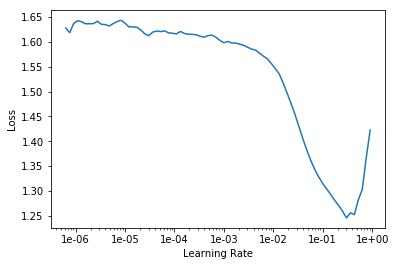

In [30]:
learn.recorder.plot()

In [32]:
lr=5e-1
learn.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,time


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/mattw/anaconda3/envs/cv/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/mattw/anaconda3/envs/cv/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/mattw/anaconda3/envs/cv/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/mattw/anaconda3/envs/cv/lib/python3.7/site-packages/fastai/data_block.py", line 651, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/home/mattw/anaconda3/envs/cv/lib/python3.7/site-packages/fastai/data_block.py", line 120, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/home/mattw/anaconda3/envs/cv/lib/python3.7/site-packages/fastai/vision/data.py", line 355, in get
    return ImageBBox.create(*_get_size(self.x,i), *self.items[i], classes=self.classes, pad_idx=self.pad_idx)
  File "/home/mattw/anaconda3/envs/cv/lib/python3.7/site-packages/fastai/vision/image.py", line 363, in create
    return cls(flow, labels=labels, classes=classes, pad_idx=pad_idx, y_first=True, scale=scale)
  File "/home/mattw/anaconda3/envs/cv/lib/python3.7/site-packages/fastai/vision/image.py", line 345, in __init__
    labels = array([Category(l,classes[l]) for l in labels])
  File "/home/mattw/anaconda3/envs/cv/lib/python3.7/site-packages/fastai/vision/image.py", line 345, in <listcomp>
    labels = array([Category(l,classes[l]) for l in labels])
TypeError: list indices must be integers or slices, not NoneType


In [ ]:
learn.unfreeze()

In [29]:
learn.lr_find()

RuntimeError: CUDA error: device-side assert triggered

In [ ]:
learn.recorder.plot()

In [ ]:
lr=5e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

In [ ]:
def compute_corner_locations(y, im_shape=(256,256)):
    shape_vec=np.array(im_shape*2)
    bounds=((y+1)*shape_vec/2).ravel()
    corners=np.array([[bounds[1], bounds[0]], 
                      [bounds[3], bounds[0]],
                      [bounds[3], bounds[2]],
                      [bounds[1], bounds[2]],
                      [bounds[1], bounds[0]]])
    return corners

In [ ]:
x,y = next(iter(learn.data.valid_dl))
with torch.no_grad():
    yhat = learn.model(x.to('cuda'))

In [ ]:
#Reshape image block and convert to numpy for visualization: 
x_numpy=np.moveaxis(x.cpu().numpy(), (0, 2, 3, 1), (0, 1, 2, 3))

In [ ]:
fig=plt.figure(0, (20,12))
for i in range(15): 
    fig.add_subplot(3,5,i+1)
    plt.imshow(x_numpy[i].mean(axis=2), cmap='gray')
    
    corners=compute_corner_locations(y[0][i].cpu().numpy())
    plt.plot(corners[:, 0], corners[:,1], c=(0, 1, 0))
    
    corners=compute_corner_locations(yhat[i].cpu().numpy())
    plt.plot(corners[:, 0], corners[:,1], c=(0, 1, 1))
    plt.axis('off')
    plt.legend(['y', '$\hat{y}$'])